In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from utils import *

In [3]:
conf = {
    'bs':180,
    'emb_size':256,
    'arch':resnet50
}

In [4]:
train_df = pd.read_csv(PATH/'train.csv')


In [5]:
train_df['split'] = train_df.label_group % 5

In [6]:
train_df['is_valid'] = train_df.split==0
train_df

,posting_id,image,image_phash,title,label_group,split,is_valid
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,4,False
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE",2937985045,0,True
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,1,False
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi,4093212188,3,False
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,4,False
...,...,...,...,...,...,...,...
34245,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ply lapis Bisa Dicuci,3776555725,0,True
34246,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533,3,False
34247,train_614977732,fff421b78fa7284284724baf249f522e.jpg,ad27f0d08c0fcbf0,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Metal Wired Headset,4101248785,0,True
34248,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , Sapi Lokal, Jamur (Bkn Alsultan / Biocell)",1663538013,3,False


In [7]:
train_df = train_df.sort_values('label_group')

In [8]:
class ContrastiveDL(TfmdDL):
    def shuffle_fn(self, idxs):
        labels = self.dataset.items.label_group.iloc[idxs].to_list()
        unique = set(labels)
        permut =self.rng.sample(unique,len(unique))
        lbl2idx = {key:idx for idx,key in enumerate(permut)}
        res = sorted(idxs, key=lambda idx: lbl2idx[labels[idx]])
        #print(permut[:3])
        return res

In [9]:
data_block = DataBlock(blocks = (ImageBlock(), CategoryBlock(vocab=train_df.label_group.to_list())),
                 splitter=ColSplitter(),
                 #splitter=RandomSplitter(),
                 get_y=ColReader('label_group'),
                 get_x=ColReader('image', pref=PATH/'train_images'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75),
                 dl_type=ContrastiveDL
                 )
dls = data_block.dataloaders(train_df, bs=conf['bs'])

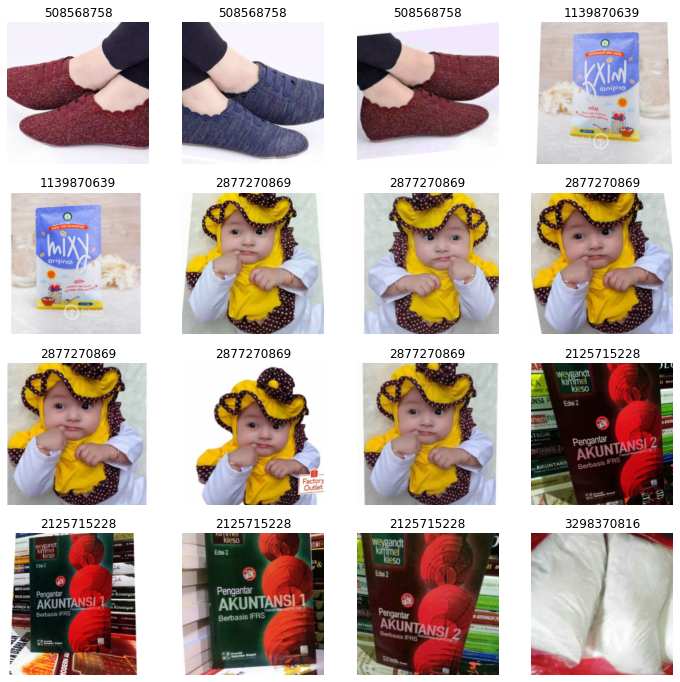

In [10]:
dls.train.show_batch(max_n=16)

In [11]:
def emb_sim(inp):
    norms=inp.norm(2,dim=1)
    normal_inp = inp /norms[:,None]
    return normal_inp @ normal_inp.T

In [12]:
def contrast_loss(inp, tar):
    simil = emb_sim(inp)
    #tar_logit = torch.tensor([tar[i]==tar[j] for i in range(tar.shape[0]) for j in range(tar.shape[0])]).float().cuda()
    n = tar.shape[0]
    tt = tar.expand(n,n)
    tar_logit = (tt==tt.T).float()
    return F.binary_cross_entropy_with_logits(simil.view(-1), tar_logit.view(-1))

In [22]:
def f1metric(x, y):
    sims = emb_sim(x)
    preds_groups=[]
    for i in range(len(sims)):
        _,tops = sims[i].topk(3)
        groups=[]
        for k in tops: groups.append(y[k.item()])
        preds_groups.append(groups)
    res =0
    all_labels = set(y.tolist())
    freqs = {lb: (y==lb).sum() for lb in all_labels}
    for preds, group in zip(preds_groups,y.tolist()):
        
        correct = preds.count(group)
        all_matches = freqs[group]
        met = 2.0 * correct / (all_matches + len(preds))
        #print(correct, all_matches, met)
        res+=met
    return res / len(preds_groups)


In [24]:
learn = cnn_learner(dls,conf['arch'], n_out = conf['emb_size'], loss_func=contrast_loss, metrics = AccumMetric(f1metric, flatten=False))

In [25]:
learn.fine_tune(50,1e-3)

epoch,train_loss,valid_loss,f1metric,time
0,0.684695,0.690619,0.541254,01:40


epoch,train_loss,valid_loss,f1metric,time
0,0.682574,0.689131,0.556195,01:58
1,0.680720,0.688546,0.561439,01:57
2,0.680999,0.687267,0.564775,01:57
3,0.679774,0.687663,0.568297,01:58
4,0.679564,0.686884,0.568649,01:58
5,0.679457,0.686677,0.571021,01:58
6,0.678550,0.686196,0.569665,01:58
7,0.677571,0.687386,0.569827,01:58
8,0.677627,0.686584,0.568832,01:58
9,0.676234,0.686116,0.569301,01:58


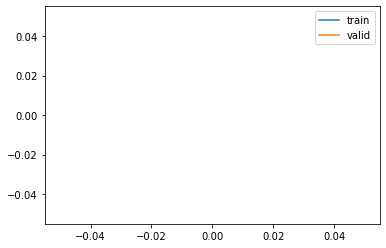

In [30]:
learn.recorder.plot_loss()

# VALIDATION STATS

In [26]:
x,y  = learn.get_preds()

In [27]:
f1metric(x,y)

TensorCategory(0.5516)

# TRAIN STATS

In [28]:
trainx, trainy = learn.get_preds(0)
trainx.shape, trainy.shape

(torch.Size([27102, 256]), torch.Size([27102]))

In [29]:
f1metric(trainx,trainy)

TensorCategory(0.5618)